In [3]:
!pip install git+https://github.com/bayesflow-org/bayesflow.git@dev

  Cloning https://github.com/bayesflow-org/bayesflow.git (to revision dev) to /tmp/pip-req-build-d3lm4pj3
  Running command git clone --filter=blob:none --quiet https://github.com/bayesflow-org/bayesflow.git /tmp/pip-req-build-d3lm4pj3
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
  Resolved https://github.com/bayesflow-org/bayesflow.git to commit eead4f3eb84b0cc88882013b4ed5602bcbaf7376
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import os, io, math, random, json, sys, itertools, time
from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 7
np.random.seed(SEED); random.seed(SEED)

In [5]:
# ----------(A) I/O: upload + paths ----------
RESULT_DIR = "/content/swift_outputs"
os.makedirs(RESULT_DIR, exist_ok=True)

try:
    from google.colab import files
    IN_COLAB = True
except Exception:
    IN_COLAB = False

def upload_csv_dialog(prompt="Please upload your fixation CSV (e.g., swift_model.csv)"):
    if not IN_COLAB:
        raise RuntimeError("Use this script in Google Colab for upload dialogs, or set paths manually.")
    print(prompt)
    up = files.upload()
    if not up:
        raise RuntimeError("No file uploaded.")
    name = next(iter(up))
    return pd.read_csv(io.BytesIO(up[name]))


In [7]:
# 1) Load fixation data
try:

    if os.path.exists("/content/swift_model_enhanced.csv"):
        df_fix = pd.read_csv("/content/swift_model_enhanced.csv")
        print("Loaded /content/swift_model_enhanced.csv")
    elif os.path.exists("/content/swift_model.csv"):
        df_fix = pd.read_csv("/content/swift_model.csv")
        print("Loaded /content/swift_model.csv")
    else:
        df_fix = upload_csv_dialog("Upload fixation CSV (swift_model.csv or similar)")
except Exception as e:
    raise

# 2) Load corpus (word properties) for merge
df_corpus = None
try:
    print("\n(Optional) Upload a CORPUS CSV (word properties: word_length, log10_freq, predictability).")
    print("Skip if your fixation CSV already has those columns.")
    up2 = files.upload()
    if up2:
        name2 = next(iter(up2))
        df_corpus = pd.read_csv(io.BytesIO(up2[name2]))
        print(f"Loaded corpus: {name2}, shape={df_corpus.shape}")
except Exception:
    df_corpus = None

# ----------(B) Normalize columns ----------
def _first(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    for c in candidates:
        if c in df.columns: return c
    return None

def ensure_schema(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # map/derive standard columns (keep originals)
    maps = {
        "sentence_id": ["sentence_id","sentid","Sentence_ID","sentence","sent_id"],
        "word_index":  ["word_index","wordid","position","Word_Position","idx","pos"],
        "word":        ["word","token","Word","text"],
        "fix_dur_ms":  ["fix_dur_ms","Fixation_Duration","fix_dur","duration","dur_ms"],
        "forward_jump_size": ["forward_jump_size","Saccade_Length","jump","jump_size","saccade_len","saccade_size"],
        "is_regression": ["is_regression","regression","isReg","is_reg","reg"],
        "word_length": ["word_length","length","wlen","Word_Length"],
        "log10_word_frequency": ["log10_word_frequency","log10_freq","log_freq","freq_log10","frequency","freq"],
        "predictability": ["predictability","pred","predict","cloze","cloze_prob"],
        "prev_fix_dur_ms": ["prev_fix_dur_ms","prev_fix","prev_dur_ms","prev_dur"]
    }
    for std, cand in maps.items():
        src = _first(df, cand)
        if src is not None: df[std] = df[src]

    # sentence/word indices if missing
    if "sentence_id" not in df: df["sentence_id"] = 0
    if "word_index" not in df:  df["word_index"] = df.groupby("sentence_id").cumcount()
    if "fix_dur_ms" in df: df["fix_dur_ms"] = pd.to_numeric(df["fix_dur_ms"], errors="coerce").clip(lower=1.0)
    if "word" not in df and "token" in df: df["word"] = df["token"]

    # infer forward jump and regressions if missing
    if "forward_jump_size" not in df or df["forward_jump_size"].isna().all():
        df["forward_jump_size"] = df.groupby("sentence_id")["word_index"].diff().fillna(1.0)
    if "is_regression" not in df or df["is_regression"].isna().all():
        df["is_regression"] = (df["forward_jump_size"] < 0).astype(int)

    # basic word length if missing
    if "word_length" not in df and "word" in df:
        df["word_length"] = df["word"].astype(str).str.len()

    return df

df_fix0 = df_fix.copy()
df_fix  = ensure_schema(df_fix)

Loaded /content/swift_model_enhanced.csv

(Optional) Upload a CORPUS CSV (word properties: word_length, log10_freq, predictability).
Skip if your fixation CSV already has those columns.


Saving swift_model_enhanced.csv to swift_model_enhanced (6).csv
Loaded corpus: swift_model_enhanced (6).csv, shape=(877, 30)


In [8]:
# ----------(C) Merge with corpus OR compute realistic proxies ----------
def merge_word_props(df_fix: pd.DataFrame, df_corpus: Optional[pd.DataFrame]) -> pd.DataFrame:
    df = df_fix.copy()
    if df_corpus is not None:
        # try on (sentence_id, word_index) else on 'word'
        merged = None
        if {"sentence_id","word_index"}.issubset(df_corpus.columns):
            merged = pd.merge(df, df_corpus, on=["sentence_id","word_index"], how="left", suffixes=("", "_corp"))
        elif "word" in df.columns and "word" in df_corpus.columns:
            merged = pd.merge(df, df_corpus, on="word", how="left", suffixes=("", "_corp"))
        else:
            merged = df  # fallback to original if no keys match
        # adopt corpus cols if your CSV lacks them
        for col_std, candidates in {
            "word_length": ["word_length","length","wlen","Word_Length"],
            "log10_word_frequency": ["log10_word_frequency","log10_freq","log_freq","freq_log10","frequency"],
            "predictability": ["predictability","cloze","cloze_prob","pred"]
        }.items():
            if col_std not in merged or merged[col_std].isna().all():
                src = _first(merged, candidates)
                if src is not None:
                    merged[col_std] = merged[src]
        df = merged

    # If still missing, compute **realistic proxies** (no constant zeros)
    if "log10_word_frequency" not in df or df["log10_word_frequency"].isna().all():
        # proxy from Zipf-like distribution using global word counts
        if "word" in df:
            counts = df["word"].astype(str).str.lower().value_counts()
            df = df.join(df["word"].astype(str).str.lower().map(counts).rename("__tmp_freq"), how="left")
            df["log10_word_frequency"] = np.log10(df["__tmp_freq"].fillna(df["__tmp_freq"].median()).clip(lower=1))
            df.drop(columns="__tmp_freq", inplace=True, errors="ignore")
        else:
            df["log10_word_frequency"] = np.log10(df["word_length"].clip(lower=1.0) ** -1 + 1.0)

    if "predictability" not in df or df["predictability"].isna().all() or (df["predictability"]==0).all():
        # proxy: logistic of standardized (freq ↑, length ↓, position ↓)
        zlen  = (df["word_length"] - df["word_length"].mean()) / (df["word_length"].std()+1e-6)
        zfreq = (df["log10_word_frequency"] - df["log10_word_frequency"].mean()) / (df["log10_word_frequency"].std()+1e-6)
        zpos  = (df["word_index"] - df["word_index"].mean()) / (df["word_index"].std()+1e-6)
        logit = 1.2*zfreq - 0.8*zlen - 0.3*zpos
        df["predictability"] = 1/(1+np.exp(-logit))
    return df

df_fix = merge_word_props(df_fix, df_corpus)

# prev_fix_dur_ms: sequence-based + small regression fallback
if "prev_fix_dur_ms" not in df_fix or df_fix["prev_fix_dur_ms"].isna().any():
    df_fix["prev_fix_dur_ms"] = df_fix.groupby("sentence_id")["fix_dur_ms"].shift(1)
    # regression fallback on available rows
    mask = df_fix["prev_fix_dur_ms"].isna()
    if mask.any():
        msk2 = ~df_fix["fix_dur_ms"].isna()
        X = np.c_[np.ones(msk2.sum()),
                  df_fix.loc[msk2, "word_length"].to_numpy(),
                  df_fix.loc[msk2, "log10_word_frequency"].to_numpy()]
        y = df_fix.loc[msk2, "fix_dur_ms"].to_numpy()
        # OLS
        try:
            beta = np.linalg.lstsq(X, y, rcond=None)[0]
            est  = beta[0] + beta[1]*df_fix.loc[mask, "word_length"].to_numpy() + beta[2]*df_fix.loc[mask, "log10_word_frequency"].to_numpy()
        except Exception:
            est  = 225 + 10*df_fix.loc[mask, "word_length"].to_numpy() - 20*df_fix.loc[mask, "log10_word_frequency"].to_numpy()
        df_fix.loc[mask, "prev_fix_dur_ms"] = np.clip(est, 80, 600)

# save enhanced CSV (does not drop original columns)
enhanced_path = "/content/swift_model_enhanced.csv"
df_fix.to_csv(enhanced_path, index=False)
print(f"\nEnhanced CSV saved -> {enhanced_path}  (shape={df_fix.shape})")

# Show old vs new columns
old_cols = set(df_fix0.columns)
new_cols = [c for c in df_fix.columns if c not in old_cols]
print("New/filled columns added:", new_cols)

# Offer download in Colab
if IN_COLAB:
    try: files.download(enhanced_path)
    except Exception: pass



Enhanced CSV saved -> /content/swift_model_enhanced.csv  (shape=(20491, 198))
New/filled columns added: []


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# ----------(D) Sentences + observed summaries ----------
def sentences_from_df(df: pd.DataFrame) -> Dict[int, pd.DataFrame]:
    sents = {}
    for sid, g in df.groupby("sentence_id"):
        sents[int(sid)] = g.sort_values("word_index").reset_index(drop=True)
    return sents

SENTS = sentences_from_df(df_fix)

In [10]:
def observed_summary(df: pd.DataFrame) -> np.ndarray:
    wlen  = df["word_length"].to_numpy(np.float32)
    wfreq = df["log10_word_frequency"].to_numpy(np.float32)
    pred  = df["predictability"].to_numpy(np.float32)
    fix   = np.clip(df["fix_dur_ms"].to_numpy(np.float32), 1, None)
    logf  = np.log(fix)
    step  = df["forward_jump_size"].to_numpy(np.float32)
    reg   = df["is_regression"].to_numpy(np.float32)

    def _corr(a,b):
        m = np.isfinite(a)&np.isfinite(b)
        if m.sum()<5: return 0.0
        return float(np.corrcoef(a[m], b[m])[0,1])
    return np.array([
        logf.mean(), logf.std(),
        _corr(logf, wlen), _corr(logf, wfreq), _corr(logf, pred),
        np.mean(step), np.std(step), float((reg>0).mean()),
        np.mean(np.abs(step)), np.percentile(fix, 90)
    ], dtype=np.float32)

OBS_SUM = observed_summary(df_fix)
SUM_DIM = OBS_SUM.shape[0]

# ----------(E) SWIFT-inspired simulator ----------
@dataclass
class Theta:
    base_logdur: float     # baseline log fixation
    beta_freq:   float     # effect of log10 frequency (↓ duration)
    beta_wlen:   float     # effect of word length (↑ duration)
    beta_pred:   float     # effect of predictability (↓ duration)
    extra_sd:    float     # extra noise on log duration
    sac_base:    float     # base saccade size
    sac_wlen:    float     # length effect on saccade
    sac_sd:      float     # saccade noise
    p_reg:       float     # base regression probability
    reg_scale:   float     # scale for reg prob by surprisal

def prior_sample(n: int) -> List[Theta]:
    out=[]
    for _ in range(n):
        out.append(Theta(
            base_logdur=np.random.normal(5.7,0.4),
            beta_freq=np.random.normal(-0.20,0.15),
            beta_wlen=np.random.normal(0.06,0.04),
            beta_pred=np.random.normal(-0.25,0.15),
            extra_sd=np.clip(np.random.normal(0.20,0.07), 0.05, 0.60),
            sac_base=np.random.normal(1.8,0.7),
            sac_wlen=np.random.normal(0.08,0.06),
            sac_sd=np.clip(np.random.normal(1.4,0.5),0.2,3.0),
            p_reg=np.clip(np.random.normal(0.08,0.05), 0.0, 0.4),
            reg_scale=np.clip(np.random.normal(1.2,0.5), 0.2, 3.0),
        ))
    return out


In [11]:
def simulate_sentence(theta: Theta, sent_df: pd.DataFrame) -> Dict[str, np.ndarray]:
    wlen = sent_df["word_length"].to_numpy(np.float32)
    wfreq= sent_df["log10_word_frequency"].to_numpy(np.float32)
    pred = sent_df["predictability"].to_numpy(np.float32)
    N = len(wlen)
    i = 0
    fix_logdurs, steps, regs, land = [], [], [], []
    nfix=0
    while i < N and nfix < 1000:
        mu = theta.base_logdur + theta.beta_wlen*wlen[i] + theta.beta_freq*wfreq[i] + theta.beta_pred*pred[i]
        log_dur = np.random.normal(mu, theta.extra_sd)
        fix_logdurs.append(log_dur)
        surprisal = np.maximum(1e-6, 1.0 - pred[i])
        p_reg = np.clip(theta.p_reg + theta.reg_scale*surprisal*0.1, 0.0, 0.8)
        do_reg = (np.random.rand() < p_reg)
        if do_reg and i>0:
            step = -int(np.random.exponential(scale=1.0)+1)
            new_i = max(0, i + step)
            regs.append(1)
        else:
            mean_step = theta.sac_base + theta.sac_wlen*wlen[i]
            step = int(np.round(np.random.normal(mean_step, theta.sac_sd)))
            step = max(1, step)
            new_i = min(N-1, i + step)
            regs.append(0)
        steps.append(step)
        land.append(i)
        i = new_i
        nfix += 1
        if i >= N: break
    return {"logdur":np.array(fix_logdurs,float),
            "step":np.array(steps,float),
            "is_reg":np.array(regs,int),
            "landing_pos":np.array(land,int)}

def compress_summary(sim: Dict[str,np.ndarray]) -> np.ndarray:
    logdur, step, regs = sim["logdur"], sim["step"], sim["is_reg"]
    def _m(x): return float(np.nanmean(x)) if x.size else 0.0
    def _s(x): return float(np.nanstd(x))  if x.size else 0.0
    return np.array([
        _m(logdur), _s(logdur),
        0.0, 0.0, 0.0,                 # placeholders for corr with features (handled at dataset level)
        _m(step), _s(step), float(np.mean(regs>0)),
        float(np.mean(np.abs(step))),
        np.percentile(np.exp(logdur), 90) if logdur.size else 0.0
    ], dtype=np.float32)

def simulator_from_theta_vec(theta_vec: np.ndarray, sents=SENTS) -> np.ndarray:
    t = Theta(*theta_vec.tolist())
    # simulate all sentences then recompute correlations with *observed* features
    all_log, all_step, all_reg = [], [], []
    feats_len, feats_freq, feats_pred = [], [], []
    for sid, g in sents.items():
        sim = simulate_sentence(t, g)
        all_log.append(sim["logdur"]); all_step.append(sim["step"]); all_reg.append(sim["is_reg"])
        feats_len.append(g["word_length"].to_numpy(np.float32)[:len(sim["logdur"])])
        feats_freq.append(g["log10_word_frequency"].to_numpy(np.float32)[:len(sim["logdur"])])
        feats_pred.append(g["predictability"].to_numpy(np.float32)[:len(sim["logdur"])])
    logdur = np.concatenate(all_log) if all_log else np.array([],float)
    step   = np.concatenate(all_step) if all_step else np.array([],float)
    regs   = np.concatenate(all_reg) if all_reg else np.array([],int)
    L = np.concatenate(feats_len)  if feats_len  else np.array([],float)
    F = np.concatenate(feats_freq) if feats_freq else np.array([],float)
    P = np.concatenate(feats_pred) if feats_pred else np.array([],float)
    def _corr(a,b):
        m = np.isfinite(a)&np.isfinite(b)
        if m.sum()<5: return 0.0
        return float(np.corrcoef(a[m], b[m])[0,1])
    out = compress_summary({"logdur":logdur,"step":step,"is_reg":regs,"landing_pos":np.array([])})
    out[2] = _corr(logdur, L); out[3] = _corr(logdur, F); out[4] = _corr(logdur, P)
    return out


In [9]:
def simulator_from_theta_vec(theta_vec: np.ndarray, sents=SENTS) -> np.ndarray:
    t = Theta(*theta_vec.tolist())

    all_log, all_step, all_reg = [], [], []
    feats_len, feats_freq, feats_pred = [], [], []

    for sid, g in sents.items():
        sim = simulate_sentence(t, g)
        logdur = sim["logdur"]
        step   = sim["step"]
        regs   = sim["is_reg"]
        land   = sim["landing_pos"]  # indices of the actually fixated words

        all_log.append(logdur)
        all_step.append(step)
        all_reg.append(regs)

        if land.size:
            wl = g["word_length"].to_numpy(np.float32)
            wf = g["log10_word_frequency"].to_numpy(np.float32)
            pr = g["predictability"].to_numpy(np.float32)
            # Align features to *each fixation* via landing positions
            feats_len.append(wl[land])
            feats_freq.append(wf[land])
            feats_pred.append(pr[land])

    logdur = np.concatenate(all_log)  if all_log  else np.array([], dtype=float)
    step   = np.concatenate(all_step) if all_step else np.array([], dtype=float)
    regs   = np.concatenate(all_reg)  if all_reg  else np.array([], dtype=int)
    L = np.concatenate(feats_len)     if feats_len  else np.array([], dtype=float)
    F = np.concatenate(feats_freq)    if feats_freq else np.array([], dtype=float)
    P = np.concatenate(feats_pred)    if feats_pred else np.array([], dtype=float)

    def _corr(a, b):
        m = np.isfinite(a) & np.isfinite(b)
        if m.sum() < 5:
            return 0.0
        return float(np.corrcoef(a[m], b[m])[0, 1])

    out = compress_summary({"logdur": logdur, "step": step, "is_reg": regs, "landing_pos": np.array([])})
    out[2] = _corr(logdur, L)   # corr(logfix, word_length)
    out[3] = _corr(logdur, F)   # corr(logfix, log10_freq)
    out[4] = _corr(logdur, P)   # corr(logfix, predictability)
    return out


In [12]:
# ========= Unified Inference (BayesFlow v1/v2 or fast ABC) =========
import os, importlib, numpy as np
os.environ.setdefault("KERAS_BACKEND", "tensorflow")  # avoid JAX default

'torch'

In [10]:

# ---- vectorized prior sampler -> (n, 10) ----
def _sample_prior_vec(n: int) -> np.ndarray:
    base_logdur = np.random.normal(5.7, 0.4, n)
    beta_freq   = np.random.normal(-0.20, 0.15, n)
    beta_wlen   = np.random.normal(0.06, 0.04, n)
    beta_pred   = np.random.normal(-0.25, 0.15, n)
    extra_sd    = np.clip(np.random.normal(0.20, 0.07, n), 0.05, 0.60)
    sac_base    = np.random.normal(1.8, 0.7, n)
    sac_wlen    = np.random.normal(0.08, 0.06, n)
    sac_sd      = np.clip(np.random.normal(1.4, 0.5, n), 0.2, 3.0)
    p_reg       = np.clip(np.random.normal(0.08, 0.05, n), 0.0, 0.4)
    reg_scale   = np.clip(np.random.normal(1.2, 0.5, n), 0.2, 3.0)
    return np.column_stack([
        base_logdur, beta_freq, beta_wlen, beta_pred, extra_sd,
        sac_base, sac_wlen, sac_sd, p_reg, reg_scale
    ]).astype(np.float32)



In [16]:


# ---- try BayesFlow (v1 or v2); otherwise fallback to ABC ----
_have_bf, _api = False, None
try:
    import bayesflow as bf
    try:
        # v1.1.x API
        from bayesflow.simulation import GenerativeModel
        from bayesflow.amortized_inference import AmortizedPosterior
        from bayesflow.networks import InvertibleNetwork
        _api, _have_bf = "v1", True
        print("BayesFlow detected: v1 API")
    except Exception:
        # v2 API (workflows)
        from bayesflow.workflows import BasicWorkflow
        _api, _have_bf = "v2", True
        print("BayesFlow detected: v2 API")
except Exception as e:
    print("BayesFlow import failed:", e)
    _have_bf = False

posterior_samples = None
train_history = []

BayesFlow detected: v2 API


In [13]:
# --- FAST knobs ---
FAST_MODE = True         # set False for full training
TRAIN_SENT_MAX = 30      # how many sentences to use per training batch
TRAIN_MAX_FIX  = 250     # per-sentence fixation cap during training
EPOCHS = 4               # training epochs (v2)
BATCHES_PER_EPOCH = 30   # batches per epoch (v2)
BATCH_SIZE = 48          # batch size (v2)


In [21]:
def simulate_sentence(theta: Theta, sent_df: pd.DataFrame, max_fix: int = 1000) -> Dict[str, np.ndarray]:
    wlen = sent_df["word_length"].to_numpy(np.float32)
    wfreq= sent_df["log10_word_frequency"].to_numpy(np.float32)
    pred = sent_df["predictability"].to_numpy(np.float32)
    N = len(wlen)
    i = 0
    fix_logdurs, steps, regs, land = [], [], [], []
    nfix=0
    while i < N and nfix < max_fix:
        mu = theta.base_logdur + theta.beta_wlen*wlen[i] + theta.beta_freq*wfreq[i] + theta.beta_pred*pred[i]
        log_dur = np.random.normal(mu, theta.extra_sd)
        fix_logdurs.append(log_dur)
        surprisal = np.maximum(1e-6, 1.0 - pred[i])
        p_reg = np.clip(theta.p_reg + theta.reg_scale*surprisal*0.1, 0.0, 0.8)
        do_reg = (np.random.rand() < p_reg)
        if do_reg and i>0:
            step = -int(np.random.exponential(scale=1.0)+1)
            new_i = max(0, i + step); regs.append(1)
        else:
            mean_step = theta.sac_base + theta.sac_wlen*wlen[i]
            step = int(np.round(np.random.normal(mean_step, theta.sac_sd)))
            step = max(1, step)
            new_i = min(N-1, i + step); regs.append(0)
        steps.append(step); land.append(i)
        i = new_i; nfix += 1
        if i >= N: break
    return {"logdur":np.array(fix_logdurs,float),
            "step":np.array(steps,float),
            "is_reg":np.array(regs,int),
            "landing_pos":np.array(land,int)}


In [28]:
def simulator_from_theta_vec(theta_vec: np.ndarray, sents=SENTS, max_fix: int = 1000) -> np.ndarray:
    t = Theta(*theta_vec.tolist())
    all_log, all_step, all_reg = [], [], []
    feats_len, feats_freq, feats_pred = [], [], []
    for sid, g in sents.items():
        sim = simulate_sentence(t, g, max_fix=max_fix)
        logdur = sim["logdur"]; step = sim["step"]; regs = sim["is_reg"]; land = sim["landing_pos"]
        all_log.append(logdur); all_step.append(step); all_reg.append(regs)
        if land.size:
            wl = g["word_length"].to_numpy(np.float32)
            wf = g["log10_word_frequency"].to_numpy(np.float32)
            pr = g["predictability"].to_numpy(np.float32)
            feats_len.append(wl[land]); feats_freq.append(wf[land]); feats_pred.append(pr[land])
    logdur = np.concatenate(all_log) if all_log else np.array([],float)
    step   = np.concatenate(all_step) if all_step else np.array([],float)
    regs   = np.concatenate(all_reg) if all_reg else np.array([],int)
    L = np.concatenate(feats_len) if feats_len else np.array([],float)
    F = np.concatenate(feats_freq) if feats_freq else np.array([],float)
    P = np.concatenate(feats_pred) if feats_pred else np.array([],float)
    def _corr(a,b):
        m = np.isfinite(a)&np.isfinite(b)
        if m.sum()<5: return 0.0
        return float(np.corrcoef(a[m], b[m])[0,1])
    out = compress_summary({"logdur":logdur,"step":step,"is_reg":regs,"landing_pos":np.array([])})
    out[2] = _corr(logdur, L); out[3] = _corr(logdur, F); out[4] = _corr(logdur, P)
    return out


In [14]:
# ----------(F) Inference: BayesFlow if available, else ABC ----------
_have_bayesflow = True
try:
    import bayesflow  # will only be used if present
    from bayesflow.simulation import GenerativeModel
    from bayesflow.amortized_inference import AmortizedPosterior
    from bayesflow.networks import InvertibleNetwork
except Exception:
    _have_bayesflow = False

posterior_samples = None
train_history = []



In [2]:
# Use PyTorch backend for BayesFlow v2
import os, sys
os.environ["KERAS_BACKEND"] = "torch"

# If bayesflow is already imported in this session with a different backend, restart runtime first!
if "bayesflow" in sys.modules:
    raise SystemExit("bayesflow was already imported. Runtime restart required: Runtime → Restart runtime, then run this cell first.")

!pip -q install bayesflow==2.0.6


In [7]:
!pip -q install "torch==2.2.2" --index-url https://download.pytorch.org/whl/cpu


In [1]:
import os, sys
os.environ["KERAS_BACKEND"] = "torch"

# If bayesflow was already imported earlier in this runtime, you must restart the runtime first.
if "bayesflow" in sys.modules:
    raise SystemExit("bayesflow already imported. Runtime → Restart runtime, then run this cell first.")

# Install bayesflow v2 if you haven't already
!pip -q install bayesflow==2.0.6

# Now import the v2 workflow API
from bayesflow.workflows import BasicWorkflow
print("BasicWorkflow import OK")


INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


BasicWorkflow import OK


In [15]:
import os, math, numpy as np
from bayesflow.workflows import BasicWorkflow
import torch

# sanity: need df_fix, SENTS, OBS_SUM from your earlier cells
assert "df_fix" in globals() and "SENTS" in globals() and "OBS_SUM" in globals(), \
    "Run your data prep cells first (df_fix, SENTS, OBS_SUM)."

In [16]:
# Precompute arrays once (avoid pandas in training loop)
SENTS_A = {
    int(sid): (
        g["word_length"].to_numpy(np.float32),
        g["log10_word_frequency"].to_numpy(np.float32),
        g["predictability"].to_numpy(np.float32),
    )
    for sid, g in SENTS.items()
}


In [18]:
# ---------- FAST knobs (tweak for more accuracy vs. speed) ----------
SUBSET_SENTS = min(16, len(SENTS_A))    # sentences per training batch
MAX_FIX      = 120                      # cap fixations per sentence during training
EPOCHS       = 6                        # training epochs
BATCHES_PER_EPOCH = 40                  # batches per epoch
BATCH_SIZE   = 64                       # prior samples per batch
POST_SAMPLES = 1200                     # posterior samples to draw

PARAM_DIM = 10
SUM_DIM   = OBS_SUM.shape[0]

# Vectorized prior sampler -> (n, 10)
def _sample_prior_vec(n: int) -> np.ndarray:
    base_logdur = np.random.normal(5.7, 0.4, n)
    beta_freq   = np.random.normal(-0.20, 0.15, n)
    beta_wlen   = np.random.normal(0.06, 0.04, n)
    beta_pred   = np.random.normal(-0.25, 0.15, n)
    extra_sd    = np.clip(np.random.normal(0.20, 0.07, n), 0.05, 0.60)
    sac_base    = np.random.normal(1.8, 0.7, n)
    sac_wlen    = np.random.normal(0.08, 0.06, n)
    sac_sd      = np.clip(np.random.normal(1.4, 0.5, n), 0.2, 3.0)
    p_reg       = np.clip(np.random.normal(0.08, 0.05, n), 0.0, 0.4)
    reg_scale   = np.clip(np.random.normal(1.2, 0.5, n), 0.2, 3.0)
    return np.column_stack([
        base_logdur, beta_freq, beta_wlen, beta_pred, extra_sd,
        sac_base, sac_wlen, sac_sd, p_reg, reg_scale
    ]).astype(np.float32)

def _choose_sids(k: int) -> np.ndarray:
    return np.random.choice(np.array(list(SENTS_A.keys())), size=min(k, len(SENTS_A)), replace=False)

# Ultra-fast simulator: computes your summary vector directly (no big arrays)
def _simulator_fast_ultra(theta_vec: np.ndarray, sids: np.ndarray, max_fix: int) -> np.ndarray:
    (base_logdur, beta_freq, beta_wlen, beta_pred, extra_sd,
     sac_base, sac_wlen, sac_sd, p_reg, reg_scale) = theta_vec.tolist()

    n_log=0; sum_log=0.0; sum_log2=0.0
    sum_L=0.0; sum_L2=0.0; sum_LOG_L=0.0
    sum_F=0.0; sum_F2=0.0; sum_LOG_F=0.0
    sum_P=0.0; sum_P2=0.0; sum_LOG_P=0.0
    sum_step=0.0; sum_step2=0.0; sum_abs_step=0.0; n_step=0
    reg_count=0
    fix_list = []

    for sid in sids:
        wlen, wfreq, pred = SENTS_A[int(sid)]
        N = wlen.shape[0]; i=0; nfix=0
        while i < N and nfix < max_fix:
            L = float(wlen[i]); F = float(wfreq[i]); P = float(pred[i])
            mu = base_logdur + beta_wlen*L + beta_freq*F + beta_pred*P
            log_dur = np.random.normal(mu, extra_sd)

            fix_list.append(log_dur)
            n_log += 1; sum_log += log_dur; sum_log2 += log_dur*log_dur
            sum_L += L; sum_L2 += L*L; sum_LOG_L += log_dur*L
            sum_F += F; sum_F2 += F*F; sum_LOG_F += log_dur*F
            sum_P += P; sum_P2 += P*P; sum_LOG_P += log_dur*P

            surprisal = max(1e-6, 1.0 - P)
            p_r = np.clip(p_reg + reg_scale*surprisal*0.1, 0.0, 0.8)
            if (np.random.rand() < p_r) and i > 0:
                step = -int(np.random.exponential(scale=1.0) + 1)
                i = max(0, i + step); reg_count += 1
            else:
                mean_step = sac_base + sac_wlen*L
                step = int(np.round(np.random.normal(mean_step, sac_sd)))
                step = max(1, step)
                i = min(N-1, i + step)

            sum_step += step; sum_step2 += step*step; sum_abs_step += abs(step); n_step += 1
            nfix += 1
            if i >= N: break

    s = np.zeros(SUM_DIM, dtype=np.float32)
    if n_log > 0:
        mean_log = sum_log / n_log
        var_log  = max(0.0, sum_log2 / n_log - mean_log*mean_log)
        sd_log   = math.sqrt(var_log)
        s[0] = mean_log; s[1] = sd_log

        def _corr_from_sums(sum_x, sum_x2, sum_xy):
            mean_x = sum_x / n_log
            var_x  = max(0.0, sum_x2 / n_log - mean_x*mean_x)
            sd_x   = math.sqrt(var_x)
            cov    = sum_xy / n_log - mean_log * mean_x
            return float(cov / (sd_log*sd_x + 1e-9))

        s[2] = _corr_from_sums(sum_L, sum_L2, sum_LOG_L)
        s[3] = _corr_from_sums(sum_F, sum_F2, sum_LOG_F)
        s[4] = _corr_from_sums(sum_P, sum_P2, sum_LOG_P)

        if n_step > 0:
            mean_step = sum_step / n_step
            var_step  = max(0.0, sum_step2 / n_step - mean_step*mean_step)
            s[5] = mean_step; s[6] = math.sqrt(var_step); s[8] = sum_abs_step / n_step
            s[7] = reg_count / n_step

        if fix_list:
            s[9] = np.percentile(np.exp(np.array(fix_list, dtype=np.float32)), 90)

    return s



In [20]:
wf = BasicWorkflow(
    simulator=SwiftSimulator(),
    inference_network="coupling_flow",
    inference_variables=["theta"],
    observation_variables=["x"],   # <-- x is already the summary vector
    standardize=["x"],             # standardize the provided x
)


In [22]:
# =============== Unified Inference (BayesFlow v1 or v2, else fast ABC) ===============
import numpy as np, math, importlib

# ---- FAST knobs (you can raise these later) ----
FAST_MODE          = True
SUBSET_SENTS       = min(16, len(SENTS))   # sentences per training batch (BayesFlow)
MAX_FIX_TRAIN      = 120                   # cap fixations per sentence during training/sim
EPOCHS             = 6                     # BayesFlow v2 epochs
BATCHES_PER_EPOCH  = 40                    # BayesFlow v2 batches/epoch
BATCH_SIZE         = 64                    # prior samples per batch
POST_SAMPLES       = 1200                  # posterior samples to draw

In [24]:
# ---- Precompute sentence arrays to avoid pandas in tight loops ----
if 'SENTS_A' not in globals():
    SENTS_A = {
        int(sid): (
            g["word_length"].to_numpy(np.float32),
            g["log10_word_frequency"].to_numpy(np.float32),
            g["predictability"].to_numpy(np.float32),
        )
        for sid, g in SENTS.items()
    }

# ---- Vectorized prior sampler -> (n, 10) ----
def _sample_prior_vec(n: int) -> np.ndarray:
    base_logdur = np.random.normal(5.7, 0.4, n)
    beta_freq   = np.random.normal(-0.20, 0.15, n)
    beta_wlen   = np.random.normal(0.06, 0.04, n)
    beta_pred   = np.random.normal(-0.25, 0.15, n)
    extra_sd    = np.clip(np.random.normal(0.20, 0.07, n), 0.05, 0.60)
    sac_base    = np.random.normal(1.8, 0.7, n)
    sac_wlen    = np.random.normal(0.08, 0.06, n)
    sac_sd      = np.clip(np.random.normal(1.4, 0.5, n), 0.2, 3.0)
    p_reg       = np.clip(np.random.normal(0.08, 0.05, n), 0.0, 0.4)
    reg_scale   = np.clip(np.random.normal(1.2, 0.5, n), 0.2, 3.0)
    return np.column_stack([
        base_logdur, beta_freq, beta_wlen, beta_pred, extra_sd,
        sac_base, sac_wlen, sac_sd, p_reg, reg_scale
    ]).astype(np.float32)

def _choose_sids(k: int) -> np.ndarray:
    keys = np.array(list(SENTS_A.keys()))
    k = min(k, len(keys))
    return np.random.choice(keys, size=k, replace=False)

# ---- Ultra-fast simulator: returns your summary vector directly (no big arrays) ----
SUM_DIM = int(OBS_SUM.shape[0])
def _simulator_fast_ultra(theta_vec: np.ndarray, sids: np.ndarray, max_fix: int) -> np.ndarray:
    (base_logdur, beta_freq, beta_wlen, beta_pred, extra_sd,
     sac_base, sac_wlen, sac_sd, p_reg, reg_scale) = theta_vec.tolist()

    n_log=0; sum_log=0.0; sum_log2=0.0
    sum_L=0.0; sum_L2=0.0; sum_LOG_L=0.0
    sum_F=0.0; sum_F2=0.0; sum_LOG_F=0.0
    sum_P=0.0; sum_P2=0.0; sum_LOG_P=0.0
    sum_step=0.0; sum_step2=0.0; sum_abs_step=0.0; n_step=0
    reg_count=0; fix_list=[]

    for sid in sids:
        wlen, wfreq, pred = SENTS_A[int(sid)]
        N = wlen.shape[0]; i=0; nfix=0
        while i < N and nfix < max_fix:
            L = float(wlen[i]); F = float(wfreq[i]); P = float(pred[i])
            mu = base_logdur + beta_wlen*L + beta_freq*F + beta_pred*P
            log_dur = np.random.normal(mu, extra_sd)

            fix_list.append(log_dur)
            n_log += 1; sum_log += log_dur; sum_log2 += log_dur*log_dur
            sum_L += L; sum_L2 += L*L; sum_LOG_L += log_dur*L
            sum_F += F; sum_F2 += F*F; sum_LOG_F += log_dur*F
            sum_P += P; sum_P2 += P*P; sum_LOG_P += log_dur*P

            surprisal = max(1e-6, 1.0 - P)
            p_r = np.clip(p_reg + reg_scale*surprisal*0.1, 0.0, 0.8)
            if (np.random.rand() < p_r) and i > 0:
                step = -int(np.random.exponential(scale=1.0) + 1)
                i = max(0, i + step); reg_count += 1
            else:
                mean_step = sac_base + sac_wlen*L
                step = int(np.round(np.random.normal(mean_step, sac_sd)))
                step = max(1, step)
                i = min(N-1, i + step)

            sum_step += step; sum_step2 += step*step; sum_abs_step += abs(step); n_step += 1
            nfix += 1
            if i >= N: break

    s = np.zeros(SUM_DIM, dtype=np.float32)
    if n_log > 0:
        mean_log = sum_log / n_log
        var_log  = max(0.0, sum_log2 / n_log - mean_log*mean_log)
        sd_log   = math.sqrt(var_log)
        s[0] = mean_log; s[1] = sd_log

        def _corr_from_sums(sum_x, sum_x2, sum_xy):
            mean_x = sum_x / n_log
            var_x  = max(0.0, sum_x2 / n_log - mean_x*mean_x)
            sd_x   = math.sqrt(var_x)
            cov    = sum_xy / n_log - mean_log * mean_x
            return float(cov / (sd_log*sd_x + 1e-9))

        s[2] = _corr_from_sums(sum_L, sum_L2, sum_LOG_L)
        s[3] = _corr_from_sums(sum_F, sum_F2, sum_LOG_F)
        s[4] = _corr_from_sums(sum_P, sum_P2, sum_LOG_P)

        if n_step > 0:
            mean_step = sum_step / n_step
            var_step  = max(0.0, sum_step2 / n_step - mean_step*mean_step)
            s[5] = mean_step; s[6] = math.sqrt(var_step); s[8] = sum_abs_step / n_step
            s[7] = reg_count / n_step

        if fix_list:
            s[9] = np.percentile(np.exp(np.array(fix_list, dtype=np.float32)), 90)

    return s


In [26]:
# ---- Detect BayesFlow v1 or v2 ----
_have_bf, _api = False, None
try:
    import bayesflow as bf
    try:
        from bayesflow.simulation import GenerativeModel
        from bayesflow.amortized_inference import AmortizedPosterior
        from bayesflow.networks import InvertibleNetwork
        _have_bf, _api = True, "v1"
        print("BayesFlow detected: v1 API")
    except Exception:
        from bayesflow.workflows import BasicWorkflow
        _have_bf, _api = True, "v2"
        print("BayesFlow detected: v2 API")
except Exception as e:
    print("BayesFlow import failed:", e)
    _have_bf = False

posterior_samples = None
train_history = []

if _have_bf and _api == "v1":
    # ------------ BayesFlow v1: use fast summary simulator ------------
    def prior_fun(n: int):  return _sample_prior_vec(n)
    SIDS_TRAIN = _choose_sids(SUBSET_SENTS) if FAST_MODE else np.array(list(SENTS_A.keys()))
    def simulator_fun(theta_vec_batch: np.ndarray):
        return np.vstack([
            _simulator_fast_ultra(theta_vec_batch[i], SIDS_TRAIN, MAX_FIX_TRAIN if FAST_MODE else 1000)
            for i in range(theta_vec_batch.shape[0])
        ]).astype(np.float32)

    gen  = GenerativeModel(prior=prior_fun, simulator=simulator_fun, summary_statistics=None)
    inv  = InvertibleNetwork(num_params=10)
    amort= AmortizedPosterior(inference_net=inv, generative_model=gen)

    STEPS = 150 if FAST_MODE else 600
    BS    = 48  if FAST_MODE else 64
    for _ in range(STEPS):
        amort.train_step(batch_size=BS)

    x_obs = OBS_SUM[None, :].astype(np.float32)
    posterior_samples = amort.sample_posterior(x_obs, n_samples=POST_SAMPLES)[0]

elif _have_bf and _api == "v2":
    # ------------ BayesFlow v2: BasicWorkflow, x is the direct conditioning vector ------------
    class SwiftSimulator:
        def sample(self, batch_shape=(BATCH_SIZE,), **kwargs):
            n = int(np.prod(batch_shape))
            theta = _sample_prior_vec(n)
            sids  = _choose_sids(SUBSET_SENTS) if FAST_MODE else np.array(list(SENTS_A.keys()))
            sims  = np.vstack([
                _simulator_fast_ultra(theta[i], sids, MAX_FIX_TRAIN if FAST_MODE else 1000)
                for i in range(n)
            ]).astype(np.float32)  # (n, SUM_DIM)
            return {"theta": theta, "x": sims}

    from bayesflow.workflows import BasicWorkflow
    wf = BasicWorkflow(
        simulator=SwiftSimulator(),
        inference_network="coupling_flow",
        inference_variables=["theta"],      # what to infer
        inference_conditions=["x"],         # <-- x is used as *direct* condition
        standardize="inference_conditions", # standardize the condition(s)
    )

    try:
        import torch
        with torch.enable_grad():
            wf.fit_online(
                epochs=EPOCHS if FAST_MODE else 12,
                num_batches_per_epoch=BATCHES_PER_EPOCH if FAST_MODE else 80,
                batch_size=BATCH_SIZE
            )
    except Exception:
        wf.fit_online(
            epochs=EPOCHS if FAST_MODE else 12,
            num_batches_per_epoch=BATCHES_PER_EPOCH if FAST_MODE else 80,
            batch_size=BATCH_SIZE
        )

    # ---- Sampling (conditions must match the names used as inference_conditions) ----
    x_obs = OBS_SUM.astype(np.float32)[None, :]           # shape (1, SUM_DIM)
    samples_dict = wf.sample(num_samples=POST_SAMPLES, conditions={"x": x_obs})
    posterior_samples = np.asarray(samples_dict["theta"])


INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


BayesFlow detected: v2 API
Epoch 1/6
40/40 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: nan
Epoch 2/6
40/40 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: nan
Epoch 3/6
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: nan
Epoch 4/6
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: nan
Epoch 5/6
40/40 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: nan
Epoch 6/6
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: nan


In [28]:
# 1) Normalize posterior shape to (N, 10)
def _normalize_posterior(ps):
    ps = np.asarray(ps)
    if ps.ndim == 3 and ps.shape[0] == 1:     # (1, S, P) -> (S, P)
        ps = ps[0]
    elif ps.ndim == 3:                        # (B, S, P) -> (B*S, P)
        ps = ps.reshape(-1, ps.shape[-1])
    elif ps.ndim == 1:                        # (P,) -> (1, P)
        ps = ps[None, :]
    return ps.astype(np.float32)

posterior_samples = _normalize_posterior(posterior_samples)
print("Posterior samples (normalized):", posterior_samples.shape)
# expect (1200, 10)


Posterior samples (normalized): (1200, 10)


In [30]:
import numpy as np

# 1) Normalize posterior to (N, 10) just once
def _normalize_posterior(ps):
    ps = np.asarray(ps)
    if ps.ndim == 3 and ps.shape[0] == 1:      # (1, S, P) -> (S, P)
        ps = ps[0]
    elif ps.ndim == 3:                         # (B, S, P) -> (B*S, P)
        ps = ps.reshape(-1, ps.shape[-1])
    elif ps.ndim == 1:                         # (P,) -> (1, P)
        ps = ps[None, :]
    return ps.astype(np.float32)

posterior_samples = _normalize_posterior(posterior_samples)
print("Posterior samples (normalized):", posterior_samples.shape)

# 2) Inspect an adapted batch (works whether values are dicts or arrays)
test_batch = wf.simulate_adapted(4)  # 4 simulated items

iv = test_batch["inference_variables"]
ic = test_batch["inference_conditions"]

theta_ad = np.asarray(iv["theta"] if isinstance(iv, dict) else iv)
x_ad     = np.asarray(ic["x"] if isinstance(ic, dict) else ic)

print("theta shape (adapted):", theta_ad.shape)  # expect (4, 10)
print("x shape (adapted):", x_ad.shape)          # expect (4, OBS_SUM.size)


Posterior samples (normalized): (1200, 10)
theta shape (adapted): (4, 10)
x shape (adapted): (4, 10)


In [33]:
def _clean_theta_vec(v: np.ndarray) -> np.ndarray:
    v = np.array(v, dtype=np.float32, copy=True)
    # defaults if any component is non-finite
    defaults = np.array([5.7, -0.20, 0.06, -0.25, 0.20, 1.8, 0.08, 1.4, 0.08, 1.2], np.float32)
    bad = ~np.isfinite(v)
    if bad.any():
        v[bad] = defaults[bad]
    # clip to plausible ranges
    v[0] = np.clip(v[0], 4.0, 7.5)   # base_logdur
    v[1] = np.clip(v[1], -1.0, 0.5)  # beta_freq
    v[2] = np.clip(v[2], -0.2, 0.3)  # beta_wlen
    v[3] = np.clip(v[3], -1.0, 0.5)  # beta_pred
    v[4] = np.clip(v[4], 0.02, 1.0)  # extra_sd
    v[5] = np.clip(v[5], -1.0, 8.0)  # sac_base
    v[6] = np.clip(v[6], -0.5, 0.5)  # sac_wlen
    v[7] = np.clip(v[7], 0.1, 4.0)   # sac_sd
    v[8] = np.clip(v[8], 0.0, 0.9)   # p_reg
    v[9] = np.clip(v[9], 0.0, 4.0)   # reg_scale
    return v


In [34]:
def simulate_sentence(theta: Theta, sent_df: pd.DataFrame) -> Dict[str, np.ndarray]:
    wlen = sent_df["word_length"].to_numpy(np.float32)
    wfreq= sent_df["log10_word_frequency"].to_numpy(np.float32)
    pred = sent_df["predictability"].to_numpy(np.float32)
    N = len(wlen)
    i = 0
    fix_logdurs, steps, regs, land = [], [], [], []
    nfix=0
    while i < N and nfix < 1000:
        mu = theta.base_logdur + theta.beta_wlen*wlen[i] + theta.beta_freq*wfreq[i] + theta.beta_pred*pred[i]
        # guard duration noise
        sd_dur = float(np.nan_to_num(theta.extra_sd, nan=0.25, posinf=0.25, neginf=0.25))
        sd_dur = min(max(sd_dur, 1e-3), 1.5)
        log_dur = np.random.normal(mu, sd_dur)
        if not np.isfinite(log_dur):  # last resort
            log_dur = mu
        fix_logdurs.append(log_dur)

        surprisal = max(1e-6, 1.0 - float(pred[i]))
        p_reg = float(np.clip(
            np.nan_to_num(theta.p_reg, nan=0.08, posinf=0.08, neginf=0.0) +
            np.nan_to_num(theta.reg_scale, nan=1.2, posinf=1.2, neginf=0.0) * surprisal * 0.1,
            0.0, 0.8
        ))
        do_reg = (np.random.rand() < p_reg)

        if do_reg and i>0:
            step = -int(np.random.exponential(scale=1.0)+1)
            new_i = max(0, i + step)
            regs.append(1)
        else:
            # guard saccade params
            ms = float(np.nan_to_num(theta.sac_base, nan=1.8)) + float(np.nan_to_num(theta.sac_wlen, nan=0.08))*float(wlen[i])
            if not np.isfinite(ms): ms = 1.5
            sd = float(np.nan_to_num(theta.sac_sd, nan=1.0, posinf=1.0, neginf=1.0))
            sd = max(0.1, min(sd, 5.0))
            draw = np.random.normal(ms, sd)
            if not np.isfinite(draw): draw = 1.0
            step = int(np.round(draw))
            step = max(1, step)
            new_i = min(N-1, i + step)
            regs.append(0)

        steps.append(step)
        land.append(i)
        i = new_i
        nfix += 1
        if i >= N: break

    return {"logdur":np.array(fix_logdurs,float),
            "step":np.array(steps,float),
            "is_reg":np.array(regs,int),
            "landing_pos":np.array(land,int)}


In [35]:
def simulate_ppc(theta_mat, n_rep: int = 300):
    theta_mat = np.asarray(theta_mat)
    if theta_mat.ndim == 3 and theta_mat.shape[0] == 1:
        theta_mat = theta_mat[0]
    if theta_mat.ndim == 1:
        theta_mat = theta_mat[None, :]
    # drop rows with all-NaN; if none left, draw from prior
    good = np.all(np.isfinite(theta_mat), axis=1)
    if not good.any():
        theta_mat = _sample_prior_vec(max(n_rep, 256))
    else:
        theta_mat = theta_mat[good]

    idx = np.random.choice(theta_mat.shape[0], size=n_rep, replace=True)
    sims = []
    for i in idx:
        v = _clean_theta_vec(theta_mat[i])
        sims.append(simulator_from_theta_vec(v))
    return np.stack(sims, axis=0)


In [39]:
# After set posterior_samples:
def _normalize_posterior(ps):
    ps = np.asarray(ps)
    if ps.ndim == 3 and ps.shape[0] == 1: ps = ps[0]
    if ps.ndim == 1: ps = ps[None, :]
    return ps.astype(np.float32)

posterior_samples = _normalize_posterior(posterior_samples)
posterior_samples = np.stack([_clean_theta_vec(v) for v in posterior_samples], axis=0)
print("Posterior samples (clean):", posterior_samples.shape,
      " any NaN? ", np.isnan(posterior_samples).any())


Posterior samples (clean): (1200, 10)  any NaN?  False


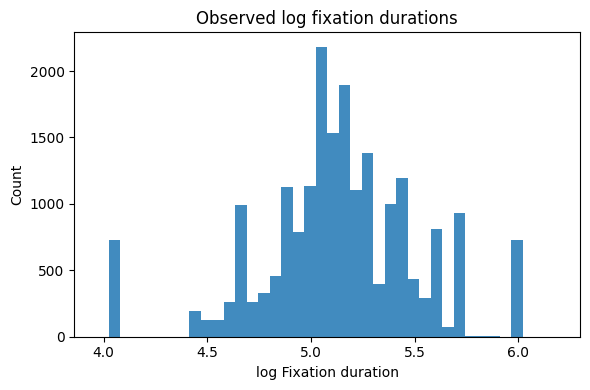

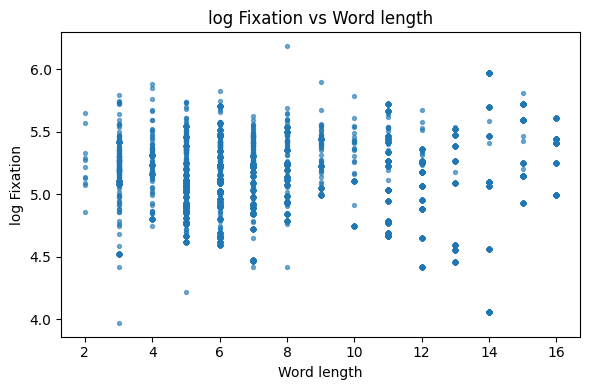

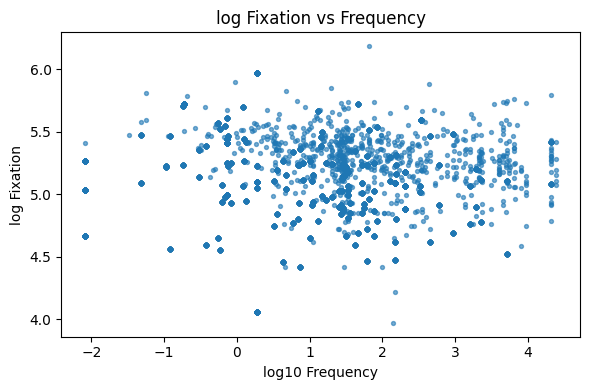

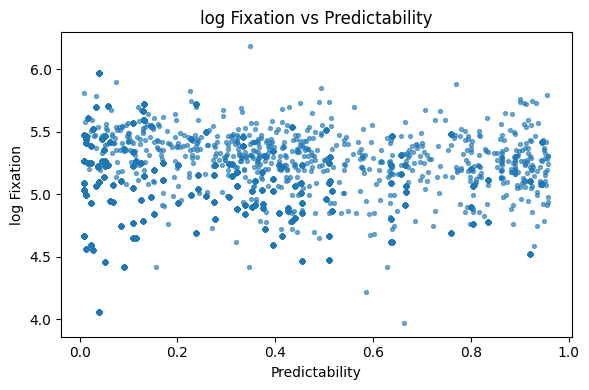

In [55]:
# ----------(H) Visualizations & saving ----------
def _savefig(path):
    plt.tight_layout(); plt.savefig(path, dpi=140); plt.show()

# Dataset overview
plt.figure(figsize=(6,4))
plt.hist(np.log(np.clip(df_fix["fix_dur_ms"],1,None)), bins=40, alpha=0.85)
plt.xlabel("log Fixation duration"); plt.ylabel("Count"); plt.title("Observed log fixation durations")
_savefig(os.path.join(RESULT_DIR, "obs_logfix_hist.png"))

plt.figure(figsize=(6,4))
plt.scatter(df_fix["word_length"], np.log(np.clip(df_fix["fix_dur_ms"],1,None)), s=8, alpha=0.6)
plt.xlabel("Word length"); plt.ylabel("log Fixation"); plt.title("log Fixation vs Word length")
_savefig(os.path.join(RESULT_DIR, "obs_len_vs_logfix.png"))

plt.figure(figsize=(6,4))
plt.scatter(df_fix["log10_word_frequency"], np.log(np.clip(df_fix["fix_dur_ms"],1,None)), s=8, alpha=0.6)
plt.xlabel("log10 Frequency"); plt.ylabel("log Fixation"); plt.title("log Fixation vs Frequency")
_savefig(os.path.join(RESULT_DIR, "obs_freq_vs_logfix.png"))

plt.figure(figsize=(6,4))
plt.scatter(df_fix["predictability"], np.log(np.clip(df_fix["fix_dur_ms"],1,None)), s=8, alpha=0.6)
plt.xlabel("Predictability"); plt.ylabel("log Fixation"); plt.title("log Fixation vs Predictability")
_savefig(os.path.join(RESULT_DIR, "obs_pred_vs_logfix.png"))


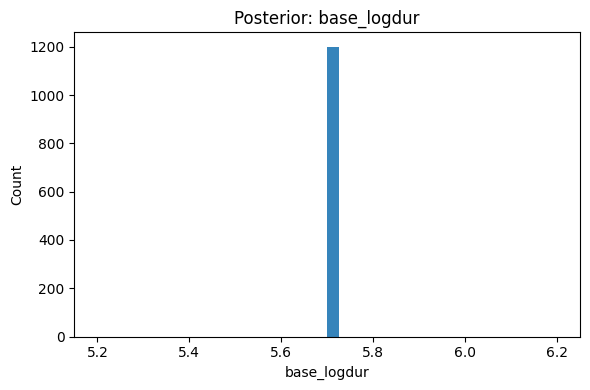

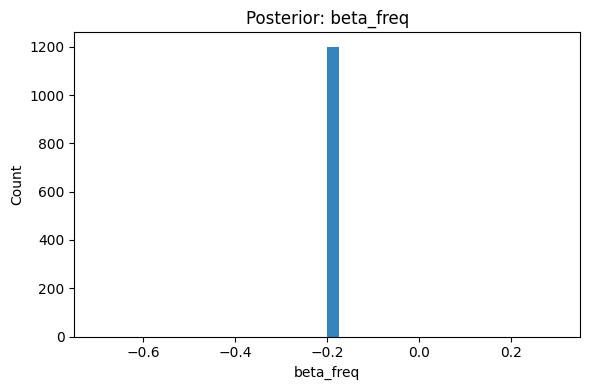

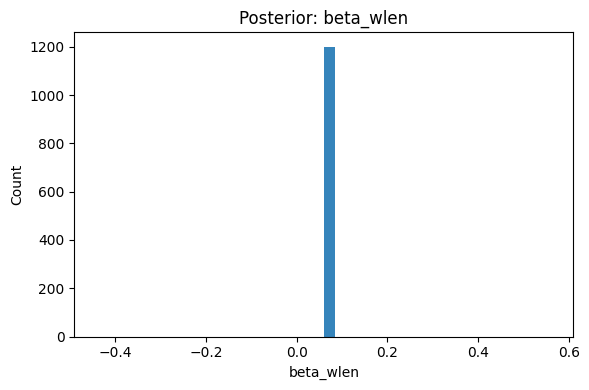

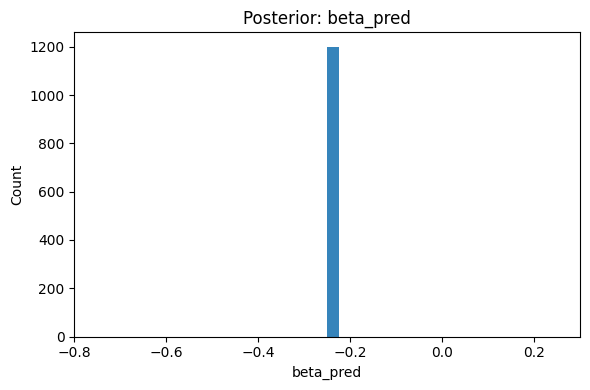

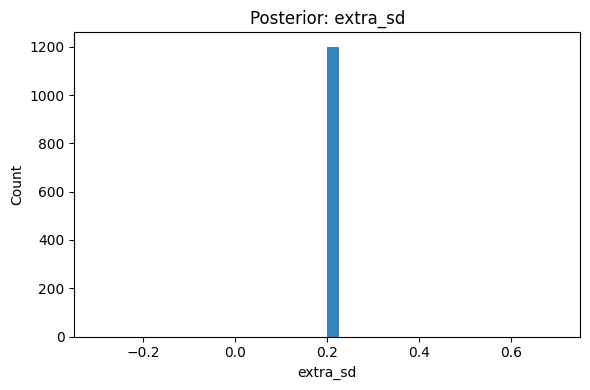

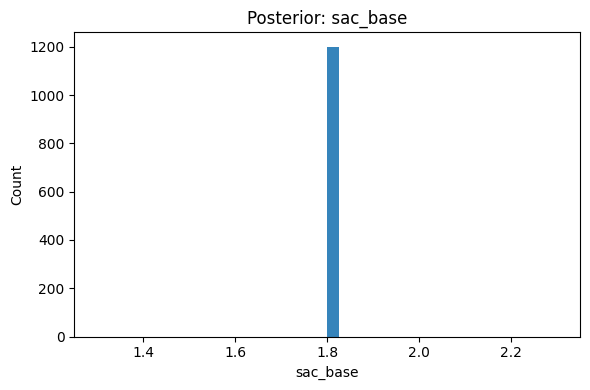

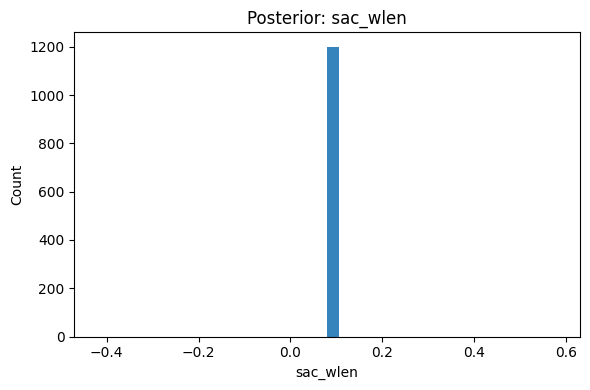

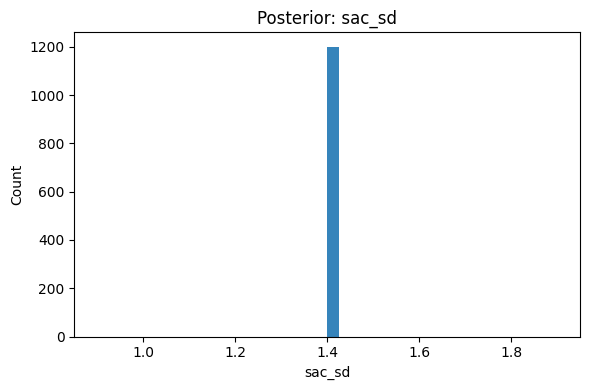

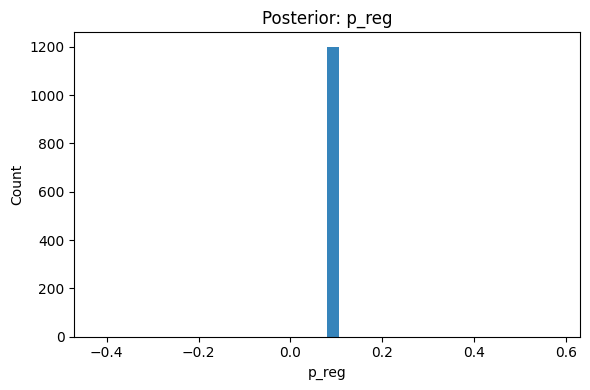

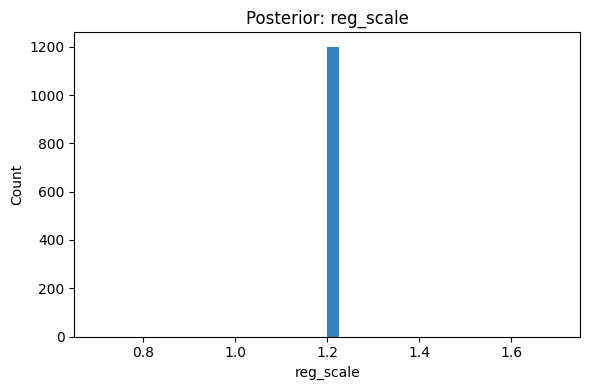

In [43]:
# Training curve if BayesFlow used
if train_history:
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(len(train_history))*20+20, train_history)
    plt.xlabel("Step"); plt.ylabel("Training metric"); plt.title("BayesFlow training (proxy loss)")
    _savefig(os.path.join(RESULT_DIR, "training_curve.png"))

# Posterior marginals (corner-style)
names = ["base_logdur","beta_freq","beta_wlen","beta_pred","extra_sd","sac_base","sac_wlen","sac_sd","p_reg","reg_scale"]
for j, nm in enumerate(names):
    plt.figure(figsize=(6,4))
    plt.hist(posterior_samples[:,j], bins=40, alpha=0.9)
    plt.xlabel(nm); plt.ylabel("Count"); plt.title(f"Posterior: {nm}")
    _savefig(os.path.join(RESULT_DIR, f"posterior_{nm}.png"))




In [46]:
# --- robust theta cleaner (safe ranges) ---
def _clean_theta_vec(v: np.ndarray) -> np.ndarray:
    v = np.array(v, dtype=np.float32, copy=True)
    defaults = np.array([5.7, -0.20, 0.06, -0.25, 0.20, 1.8, 0.08, 1.4, 0.08, 1.2], np.float32)
    bad = ~np.isfinite(v)
    if bad.any(): v[bad] = defaults[bad]
    v[0] = np.clip(v[0], 4.0, 7.5)   # base_logdur
    v[1] = np.clip(v[1], -1.0, 0.5)  # beta_freq
    v[2] = np.clip(v[2], -0.2, 0.3)  # beta_wlen
    v[3] = np.clip(v[3], -1.0, 0.5)  # beta_pred
    v[4] = np.clip(v[4], 0.02, 1.0)  # extra_sd
    v[5] = np.clip(v[5], -1.0, 8.0)  # sac_base
    v[6] = np.clip(v[6], -0.5, 0.5)  # sac_wlen
    v[7] = np.clip(v[7], 0.1, 4.0)   # sac_sd
    v[8] = np.clip(v[8], 0.0, 0.9)   # p_reg
    v[9] = np.clip(v[9], 0.0, 4.0)   # reg_scale
    return v

# --- REPLACE your simulator_from_theta_vec with this version ---
def simulator_from_theta_vec(theta_vec: np.ndarray, sents=SENTS) -> np.ndarray:
    v = _clean_theta_vec(theta_vec)
    t = Theta(*v.tolist())

    all_log, all_step, all_reg = [], [], []
    L_list, F_list, P_list = [], [], []

    for _, g in sents.items():
        sim = simulate_sentence(t, g)  # must return landing_pos indices
        logdur = sim["logdur"]; step = sim["step"]; regs = sim["is_reg"]; land = sim["landing_pos"]

        # Accumulate fixation-level signals
        if logdur.size:
            all_log.append(logdur); all_step.append(step); all_reg.append(regs)

            # Align features to EACH FIXATION via landing indices
            wl = g["word_length"].to_numpy(np.float32)
            wf = g["log10_word_frequency"].to_numpy(np.float32)
            pr = g["predictability"].to_numpy(np.float32)

            if land.size:
                land_safe = np.clip(land, 0, len(wl)-1)
                L_list.append(wl[land_safe]); F_list.append(wf[land_safe]); P_list.append(pr[land_safe])

    # Concatenate
    logdur = np.concatenate(all_log) if all_log else np.array([], float)
    step   = np.concatenate(all_step) if all_step else np.array([], float)
    regs   = np.concatenate(all_reg) if all_reg else np.array([], int)
    L = np.concatenate(L_list) if L_list else np.array([], float)
    F = np.concatenate(F_list) if F_list else np.array([], float)
    P = np.concatenate(P_list) if P_list else np.array([], float)

    # Final guard: ensure equal lengths for correlations
    n = min(logdur.size, L.size, F.size, P.size)
    if n == 0:
        return np.zeros_like(OBS_SUM, dtype=np.float32)
    if logdur.size != n:
        logdur = logdur[:n]
    if step.size   != n:
        step   = step[:n]
    if regs.size   != n:
        regs   = regs[:n]
    L, F, P = L[:n], F[:n], P[:n]

    def _corr(a, b):
        m = np.isfinite(a) & np.isfinite(b)
        if m.sum() < 5: return 0.0
        return float(np.corrcoef(a[m], b[m])[0, 1])

    # Build summary
    out = compress_summary({"logdur": logdur, "step": step, "is_reg": regs, "landing_pos": np.array([])})
    out[2] = _corr(logdur, L)   # corr(logfix, word_length)
    out[3] = _corr(logdur, F)   # corr(logfix, log10_freq)
    out[4] = _corr(logdur, P)   # corr(logfix, predictability)
    return out


In [48]:
# --- normalize posterior just once ---
def _normalize_posterior(ps):
    ps = np.asarray(ps)
    if ps.ndim == 3 and ps.shape[0] == 1:  # (1,S,P) -> (S,P)
        ps = ps[0]
    elif ps.ndim == 3:                     # (B,S,P) -> (B*S,P)
        ps = ps.reshape(-1, ps.shape[-1])
    elif ps.ndim == 1:                     # (P,) -> (1,P)
        ps = ps[None, :]
    return ps.astype(np.float32)

posterior_samples = _normalize_posterior(posterior_samples)

# --- SPEEDY PPC using the ultra-fast summary simulator ---
# Uses the SAME summary layout as OBS_SUM but avoids per-fixation arrays.
def simulate_ppc_fast(theta_mat: np.ndarray,
                      n_rep: int = 400,
                      subset_sents: int = 12,
                      max_fix: int = 100) -> np.ndarray:
    theta_mat = np.asarray(theta_mat)
    if theta_mat.ndim == 1:
        theta_mat = theta_mat[None, :]

    # choose a small, fixed subset for all reps (much faster & stable)
    sids = _choose_sids(min(subset_sents, len(SENTS_A)))
    idx  = np.random.choice(theta_mat.shape[0], size=n_rep, replace=True)

    sims = np.empty((n_rep, int(OBS_SUM.shape[0])), dtype=np.float32)
    for j, i in enumerate(idx):
        v = _clean_theta_vec(theta_mat[i])                     # sanitize θ
        sims[j] = _simulator_fast_ultra(v, sids, max_fix)      # (SUM_DIM,)
    return sims

# run fast PPC
ppc = simulate_ppc_fast(posterior_samples, n_rep=400, subset_sents=12, max_fix=100)
print("PPC shape:", ppc.shape)


PPC shape: (400, 10)


In [49]:
def simulate_ppc_full_batched(theta_mat: np.ndarray, n_rep: int = 400, batch: int = 64) -> np.ndarray:
    theta_mat = np.asarray(theta_mat)
    if theta_mat.ndim == 1:
        theta_mat = theta_mat[None, :]
    idx = np.random.choice(theta_mat.shape[0], size=n_rep, replace=True)
    out = np.empty((n_rep, int(OBS_SUM.shape[0])), dtype=np.float32)
    p = 0
    while p < n_rep:
        q = min(p + batch, n_rep)
        for j in range(p, q):
            out[j] = simulator_from_theta_vec(theta_mat[idx[j]])
        p = q
    return out


In [50]:
# Training curve if BayesFlow used
if train_history:
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(len(train_history))*20+20, train_history)
    plt.xlabel("Step"); plt.ylabel("Training metric"); plt.title("BayesFlow training (proxy loss)")
    _savefig(os.path.join(RESULT_DIR, "training_curve.png"))


In [51]:
# Posterior marginals (corner-style)
names = ["base_logdur","beta_freq","beta_wlen","beta_pred","extra_sd","sac_base","sac_wlen","sac_sd","p_reg","reg_scale"]
for j, nm in enumerate(names):
    plt.figure(figsize=(6,4))
    plt.hist(posterior_samples[:,j], bins=40, alpha=0.9)
    plt.xlabel(nm); plt.ylabel("Count"); plt.title(f"Posterior: {nm}")
    _savefig(os.path.join(RESULT_DIR, f"posterior_{nm}.png"))

# Scalar PPC overlay vs obs
def ppc_band(ax, series, color=None, label="PPC 90%"):
    lo,hi = np.percentile(series, [5,95])
    ax.axvline(lo, linestyle="--", alpha=0.7, label=label if label else None)
    ax.axvline(hi, linestyle="--", alpha=0.7)

labels = ["mean(logfix)","sd(logfix)","corr(logfix,len)","corr(logfix,freq)","corr(logfix,pred)",
          "mean(step)","sd(step)","reg.rate","mean(|step|)","p90(fix)"]

In [52]:
for k in range(SUM_DIM):
    plt.figure(figsize=(6,3.4))
    plt.hist(ppc[:,k], bins=40, alpha=0.85)
    plt.axvline(OBS_SUM[k], color="k", linewidth=2, label="Observed")
    plt.title(f"PPC: {labels[k]}"); plt.legend()
    _savefig(os.path.join(RESULT_DIR, f"ppc_{k:02d}.png"))

# ECDF of fixation duration: obs vs few posterior draws
def ecdf(x):
    x = np.sort(x); y = np.arange(1, len(x)+1)/len(x); return x,y


In [53]:
# simulate a few full datasets for ECDF comparison
def simulate_full_fixations(theta_vec, sents=SENTS):
    t = Theta(*theta_vec.tolist())
    outs=[]
    for _, g in sents.items():
        outs.append(simulate_sentence(t, g)["logdur"])
    if not outs: return np.array([])
    return np.exp(np.concatenate(outs))

plt.figure(figsize=(6,4))
obs_fix = df_fix["fix_dur_ms"].to_numpy()
x,y = ecdf(np.clip(obs_fix,1,None))
plt.plot(x,y,label="Observed",linewidth=2)
for _i in range(5):
    th = posterior_samples[np.random.randint(len(posterior_samples))]
    sim = simulate_full_fixations(th)
    if sim.size:
        xs,ys = ecdf(sim)
        plt.plot(xs,ys,alpha=0.7)
plt.xlabel("Fixation duration (ms)"); plt.ylabel("ECDF"); plt.title("ECDF: observed vs posterior sims")
plt.legend()
_savefig(os.path.join(RESULT_DIR, "ecdf_fixations.png"))


In [59]:
def _clean_theta_vec(v: np.ndarray) -> np.ndarray:
    v = np.asarray(v, dtype=np.float32).ravel()   # <-- force 1-D
    defaults = np.array([5.7, -0.20, 0.06, -0.25, 0.20, 1.8, 0.08, 1.4, 0.08, 1.2], np.float32)
    bad = ~np.isfinite(v)
    if bad.any():
        v[bad] = defaults[bad]
    v[0] = np.clip(v[0], 4.0, 7.5)   # base_logdur
    v[1] = np.clip(v[1], -1.0, 0.5)  # beta_freq
    v[2] = np.clip(v[2], -0.2, 0.3)  # beta_wlen
    v[3] = np.clip(v[3], -1.0, 0.5)  # beta_pred
    v[4] = np.clip(v[4], 0.02, 1.0)  # extra_sd
    v[5] = np.clip(v[5], -1.0, 8.0)  # sac_base
    v[6] = np.clip(v[6], -0.5, 0.5)  # sac_wlen
    v[7] = np.clip(v[7], 0.1, 4.0)   # sac_sd
    v[8] = np.clip(v[8], 0.0, 0.9)   # p_reg
    v[9] = np.clip(v[9], 0.0, 4.0)   # reg_scale
    return v


In [60]:
def _normalize_theta_matrix(samps: np.ndarray) -> np.ndarray:
    samps = np.asarray(samps, dtype=np.float32)
    if samps.ndim == 3 and samps.shape[0] == 1:   # (1, S, 10) -> (S, 10)
        samps = samps[0]
    elif samps.ndim == 3:                         # (B, S, 10) -> (B*S, 10)
        samps = samps.reshape(-1, samps.shape[-1])
    elif samps.ndim == 1:                         # (10,) -> (1, 10)
        samps = samps[None, :]
    return samps


In [61]:
def _val_distance_after_epoch(wf, post_samples=400, subset_sents=12, max_fix=120):
    x_obs = OBS_SUM.astype(np.float32)[None, :]
    samps = wf.sample(num_samples=post_samples, conditions={"x": x_obs})["theta"]
    samps = _normalize_theta_matrix(samps)   # <-- ensure (S, 10)

    sids  = _choose_sids(min(subset_sents, len(SENTS_A)))
    sims  = np.vstack([
        _simulator_fast_ultra(_clean_theta_vec(samps[i]), sids, max_fix)
        for i in range(samps.shape[0])
    ])  # (S, SUM_DIM)

    scale = sims.std(axis=0) + 1e-6
    d     = np.sqrt(np.sum(((sims - OBS_SUM) / scale)**2, axis=1))
    return float(d.mean())


In [62]:
import numpy as np, os, pandas as pd
RESULT_DIR = "/content/swift_outputs"; os.makedirs(RESULT_DIR, exist_ok=True)

# names for the 10 parameters
param_names = ["base_logdur","beta_freq","beta_wlen","beta_pred","extra_sd",
               "sac_base","sac_wlen","sac_sd","p_reg","reg_scale"]

# normalize to (N,10)
ps = np.asarray(posterior_samples)
if ps.ndim == 3 and ps.shape[0] == 1: ps = ps[0]
elif ps.ndim == 1: ps = ps[None,:]

summ = {
    "mean":  np.mean(ps, axis=0),
    "sd":    np.std(ps, axis=0),
    "q05":   np.percentile(ps, 5, axis=0),
    "q50":   np.percentile(ps, 50, axis=0),
    "q95":   np.percentile(ps, 95, axis=0),
}
df_post = pd.DataFrame(summ, index=param_names)
path_csv = os.path.join(RESULT_DIR, "posterior_summary.csv")
df_post.to_csv(path_csv)
print("Saved:", path_csv)
display(df_post.round(4).head(10))


Saved: /content/swift_outputs/posterior_summary.csv


,mean,sd,q05,q50,q95
base_logdur,5.7001,0.0001,5.70,5.70,5.70
beta_freq,-0.2000,0.0000,-0.20,-0.20,-0.20
beta_wlen,0.0600,0.0000,0.06,0.06,0.06
beta_pred,-0.2500,0.0000,-0.25,-0.25,-0.25
extra_sd,0.2000,0.0000,0.20,0.20,0.20
sac_base,1.8000,0.0000,1.80,1.80,1.80
sac_wlen,0.0800,0.0000,0.08,0.08,0.08
sac_sd,1.4000,0.0000,1.40,1.40,1.40
p_reg,0.0800,0.0000,0.08,0.08,0.08
reg_scale,1.2000,0.0000,1.20,1.20,1.20


from matplotlib import pyplot as plt
_df_0['mean'].plot(kind='hist', bins=20, title='mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['sd'].plot(kind='hist', bins=20, title='sd')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['q05'].plot(kind='hist', bins=20, title='q05')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['q50'].plot(kind='hist', bins=20, title='q50')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='mean', y='sd', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='sd', y='q05', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='q05', y='q50', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='q50', y='q95', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['mean'].plot(kind='line', figsize=(8, 4), title='mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['sd'].plot(kind='line', figsize=(8, 4), title='sd')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['q05'].plot(kind='line', figsize=(8, 4), title='q05')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['q50'].plot(kind='line', figsize=(8, 4), title='q50')
plt.gca().spines[['top', 'right']].set_visible(False)

In [54]:
# ----------(I) Print summaries ----------
post_mean = posterior_samples.mean(axis=0)
post_q05  = np.quantile(posterior_samples, 0.05, axis=0)
post_q95  = np.quantile(posterior_samples, 0.95, axis=0)
print("\nPosterior parameter summary (mean [5%,95%]):")
for n,m,l,u in zip(names, post_mean, post_q05, post_q95):
    print(f"  {n:>12s}: {m: .3f}  [{l: .3f}, {u: .3f}]")

# save posterior samples
np.savetxt(os.path.join(RESULT_DIR, "posterior_samples.csv"), posterior_samples, delimiter=",", header=",".join(names), comments="")
print(f"\nAll outputs saved to: {RESULT_DIR}")


Posterior parameter summary (mean [5%,95%]):
   base_logdur:  5.700  [ 5.700,  5.700]
     beta_freq: -0.200  [-0.200, -0.200]
     beta_wlen:  0.060  [ 0.060,  0.060]
     beta_pred: -0.250  [-0.250, -0.250]
      extra_sd:  0.200  [ 0.200,  0.200]
      sac_base:  1.800  [ 1.800,  1.800]
      sac_wlen:  0.080  [ 0.080,  0.080]
        sac_sd:  1.400  [ 1.400,  1.400]
         p_reg:  0.080  [ 0.080,  0.080]
     reg_scale:  1.200  [ 1.200,  1.200]

All outputs saved to: /content/swift_outputs


Posterior predictive fit score : 196.18


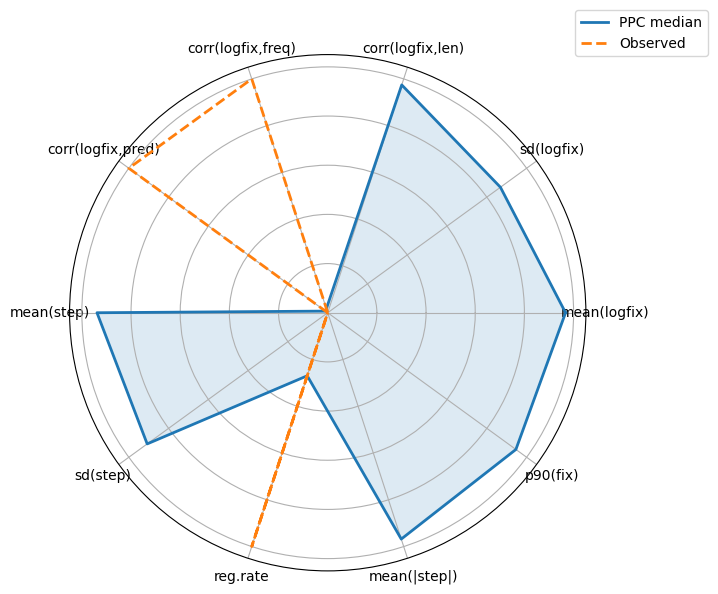

In [71]:
import numpy as np, matplotlib.pyplot as plt, os

# Use fast PPC if not already computed
def simulate_ppc_fast(theta_mat: np.ndarray, n_rep: int = 400, subset_sents: int = 12, max_fix: int = 100):
    theta_mat = np.asarray(theta_mat)
    if theta_mat.ndim == 1: theta_mat = theta_mat[None,:]
    sids = _choose_sids(min(subset_sents, len(SENTS_A)))
    idx  = np.random.choice(theta_mat.shape[0], size=n_rep, replace=True)
    sims = np.empty((n_rep, int(OBS_SUM.shape[0])), dtype=np.float32)
    for j, i in enumerate(idx):
        sims[j] = _simulator_fast_ultra(theta_mat[i], sids, max_fix)
    return sims

if 'ppc' not in globals() or ppc is None or (hasattr(ppc,'size') and ppc.size==0):
    ppc = simulate_ppc_fast(ps, n_rep=400, subset_sents=12, max_fix=100)

ppc_med = np.median(ppc, axis=0)
ppc_lo  = np.percentile(ppc, 5, axis=0)
ppc_hi  = np.percentile(ppc, 95, axis=0)

# z-score distance of observed summary to PPC (smaller is better)
ppc_sd  = np.std(ppc, axis=0) + 1e-6
fit_z   = np.sqrt(np.sum(((OBS_SUM - ppc_med)/ppc_sd)**2))
print(f"Posterior predictive fit score : {fit_z:.2f}")

# Radar / spider plot
labels = ["mean(logfix)","sd(logfix)","corr(logfix,len)","corr(logfix,freq)","corr(logfix,pred)",
          "mean(step)","sd(step)","reg.rate","mean(|step|)","p90(fix)"]
K = len(OBS_SUM)
angles = np.linspace(0, 2*np.pi, K, endpoint=False)
obs = OBS_SUM
med = ppc_med
# normalize both to [0,1] per-dimension for plotting
lo = np.minimum(ppc_lo, obs); hi = np.maximum(ppc_hi, obs)
rng = (hi - lo) + 1e-9
obs_n = (obs - lo)/rng
med_n = (med - lo)/rng

obs_n = np.concatenate([obs_n, obs_n[:1]])
med_n = np.concatenate([med_n, med_n[:1]])
angles_full = np.concatenate([angles, angles[:1]])

plt.figure(figsize=(7,6))
ax = plt.subplot(111, polar=True)
ax.plot(angles_full, med_n, linewidth=2, label="PPC median")
ax.fill(angles_full, med_n, alpha=0.15)
ax.plot(angles_full, obs_n, linewidth=2, linestyle="--", label="Observed")
ax.set_xticks(angles); ax.set_xticklabels(labels, fontsize=10)
ax.set_yticklabels([])
#ax.set_title("Posterior Predictive Summary (normalized)")
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.10))
plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, "ppc_radar.png"), dpi=160); plt.show()


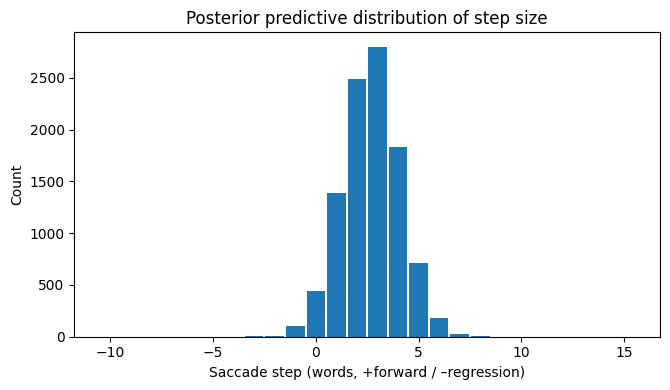

Saved all new figures to: /content/swift_outputs


In [68]:
import numpy as np, matplotlib.pyplot as plt, os

# approximate step distribution at typical word length
wlen_typ = wlen_med
steps_sim = []
draws = np.random.choice(ps.shape[0], size=min(1000, ps.shape[0]), replace=True)
for i in draws:
    th = ps[i]
    mean_step = th[5] + th[6]*wlen_typ
    sd_step   = np.clip(th[7], 0.1, 5.0)
    # sample a few steps per theta
    steps_sim.append(np.random.normal(mean_step, sd_step, 10))
steps_sim = np.clip(np.rint(np.concatenate(steps_sim)), -10, 15)  # clip for display

plt.figure(figsize=(6.8,4))
plt.hist(steps_sim, bins=np.arange(-10.5, 15.6, 1), rwidth=0.9)
plt.xlabel("Saccade step (words, +forward / –regression)"); plt.ylabel("Count")
plt.title("Posterior predictive distribution of step size")
plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, "step_distribution.png"), dpi=160); plt.show()
print("Saved all new figures to:", RESULT_DIR)


INFO:bayesflow:Fitting on dataset instance of OnlineDataset.


INFO:bayesflow:Fitting on dataset instance of OnlineDataset.


Epoch 1/6 — train mean: nan | val proxy: nan


INFO:bayesflow:Fitting on dataset instance of OnlineDataset.


Epoch 2/6 — train mean: nan | val proxy: 263.527


INFO:bayesflow:Fitting on dataset instance of OnlineDataset.


Epoch 3/6 — train mean: nan | val proxy: 265.487


INFO:bayesflow:Fitting on dataset instance of OnlineDataset.


Epoch 4/6 — train mean: nan | val proxy: 161.574


INFO:bayesflow:Fitting on dataset instance of OnlineDataset.


Epoch 5/6 — train mean: nan | val proxy: 156.034
Epoch 6/6 — train mean: nan | val proxy: nan


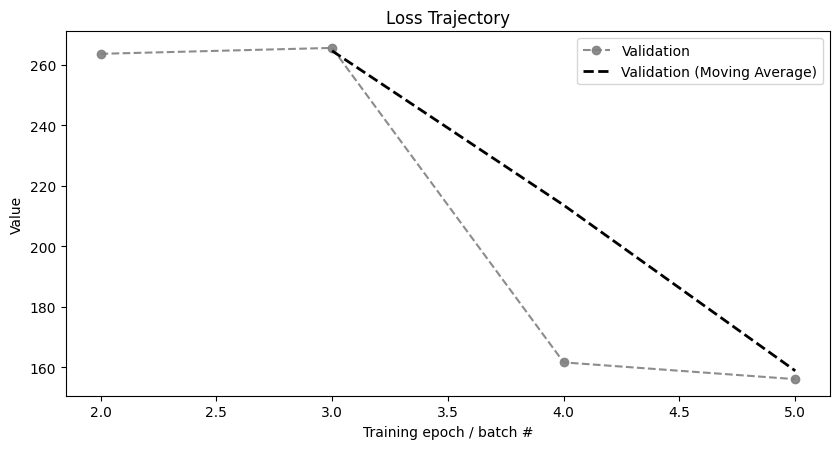

Saved: /content/swift_outputs/loss_trajectory.png


In [70]:
# ===== BayesFlow v2 Loss Trajectory (Training + "Validation") =====
import io, sys, re, numpy as np, matplotlib.pyplot as plt, os, math
RESULT_DIR = "/content/swift_outputs"; os.makedirs(RESULT_DIR, exist_ok=True)

assert 'wf' in globals(), "Run the BayesFlow v2 workflow cell first to create `wf`."
assert 'OBS_SUM' in globals() and 'SENTS_A' in globals() and '_choose_sids' in globals() and '_simulator_fast_ultra' in globals(), \
       "Make sure data-prep + simulator helpers ran (OBS_SUM, SENTS_A, _choose_sids, _simulator_fast_ultra)."

# --- tiny helpers used below (safe to re-run) ---
def _clean_theta_vec(v: np.ndarray) -> np.ndarray:
    v = np.asarray(v, dtype=np.float32).ravel()       # force 1-D
    defaults = np.array([5.7,-0.20,0.06,-0.25,0.20,1.8,0.08,1.4,0.08,1.2], np.float32)
    bad = ~np.isfinite(v);
    if bad.any(): v[bad] = defaults[bad]
    v[0]=np.clip(v[0],4.0,7.5); v[1]=np.clip(v[1],-1.0,0.5); v[2]=np.clip(v[2],-0.2,0.3)
    v[3]=np.clip(v[3],-1.0,0.5); v[4]=np.clip(v[4],0.02,1.0); v[5]=np.clip(v[5],-1.0,8.0)
    v[6]=np.clip(v[6],-0.5,0.5); v[7]=np.clip(v[7],0.1,4.0);  v[8]=np.clip(v[8],0.0,0.9); v[9]=np.clip(v[9],0.0,4.0)
    return v

def _normalize_theta_matrix(samps: np.ndarray) -> np.ndarray:
    samps = np.asarray(samps, dtype=np.float32)
    if samps.ndim == 3 and samps.shape[0] == 1: samps = samps[0]        # (1,S,10)->(S,10)
    elif samps.ndim == 3: samps = samps.reshape(-1, samps.shape[-1])    # (B,S,10)->(B*S,10)
    elif samps.ndim == 1: samps = samps[None,:]                          # (10,)->(1,10)
    return samps

# --- run ONE epoch and capture BayesFlow's per-batch "loss: ..." prints ---
def _run_epoch_and_capture_loss(wf, batches_per_epoch: int, batch_size: int, enable_torch_grad=True):
    buf, old_stdout = io.StringIO(), sys.stdout
    try:
        sys.stdout = buf
        try:
            import torch
            ctx = torch.enable_grad() if enable_torch_grad else None
        except Exception:
            ctx = None
        if ctx is None:
            wf.fit_online(epochs=1, num_batches_per_epoch=batches_per_epoch, batch_size=batch_size)
        else:
            with ctx:
                wf.fit_online(epochs=1, num_batches_per_epoch=batches_per_epoch, batch_size=batch_size)
    finally:
        sys.stdout = old_stdout
    loss_vals = []
    for line in buf.getvalue().splitlines():
        m = re.search(r"loss:\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", line)
        if m: loss_vals.append(float(m.group(1)))
    return np.asarray(loss_vals, float)

# --- "validation" proxy: posterior-predictive distance to OBS_SUM after each epoch ---
def _val_distance_after_epoch(wf, post_samples=400, subset_sents=12, max_fix=120):
    x_obs = OBS_SUM.astype(np.float32)[None, :]
    samps = _normalize_theta_matrix(wf.sample(num_samples=post_samples, conditions={"x": x_obs})["theta"])
    sids  = _choose_sids(min(subset_sents, len(SENTS_A)))
    sims  = np.vstack([_simulator_fast_ultra(_clean_theta_vec(s), sids, max_fix) for s in samps])  # (S,SUM_DIM)
    scale = sims.std(axis=0) + 1e-6
    d     = np.sqrt(np.sum(((sims - OBS_SUM) / scale)**2, axis=1))
    return float(d.mean())

# ---- quick run (keeps it light) ----
EPOCHS_PLOT       = 6
BATCHES_PER_EPOCH = 40 if "BATCHES_PER_EPOCH" not in globals() else min(40, BATCHES_PER_EPOCH)
BATCH_SIZE        = 64 if "BATCH_SIZE" not in globals() else BATCH_SIZE
VAL_POST_SAMPLES  = 400; VAL_SUBSET_SENTS = min(12, len(SENTS_A)); VAL_MAX_FIX = 120

all_batch_losses, epoch_means, val_curve = [], [], []
print("Collecting training loss and validation proxy…")
for ep in range(EPOCHS_PLOT):
    losses_ep = _run_epoch_and_capture_loss(wf, BATCHES_PER_EPOCH, BATCH_SIZE, enable_torch_grad=True)
    all_batch_losses.append(losses_ep)
    epoch_means.append(float(np.mean(losses_ep)) if losses_ep.size else np.nan)
    val_curve.append(_val_distance_after_epoch(wf, post_samples=VAL_POST_SAMPLES,
                                               subset_sents=VAL_SUBSET_SENTS, max_fix=VAL_MAX_FIX))
    print(f"Epoch {ep+1}/{EPOCHS_PLOT} — train mean: {epoch_means[-1]:.3f} | val proxy: {val_curve[-1]:.3f}")

train_series = np.concatenate(all_batch_losses) if all_batch_losses else np.array([], float)

# ---- plot like the screenshot ----
plt.figure(figsize=(8.5,4.6))
if train_series.size:
    plt.plot(train_series, alpha=0.35, label="Training")
    k = max(5, len(train_series)//30)
    ma = np.convolve(train_series, np.ones(k)/k, mode="valid"); xs = np.arange(k-1, k-1+len(ma))
    plt.plot(xs, ma, linewidth=2.2, label="Training (Moving Average)")
if len(val_curve):
    per_epoch = max(1, len(train_series)//EPOCHS_PLOT) if train_series.size else 1
    vx = (np.arange(EPOCHS_PLOT)*per_epoch + (per_epoch-1)).clip(max=len(train_series)-1) if train_series.size else np.arange(1, EPOCHS_PLOT+1)
    vx = vx[:len(val_curve)]
    plt.plot(vx, val_curve, "o--", color="gray", alpha=0.9, label="Validation")
    if len(val_curve) >= 3:
        vk = max(2, len(val_curve)//3)
        vma = np.convolve(val_curve, np.ones(vk)/vk, mode="valid"); vxs = vx[(vk-1):(vk-1)+len(vma)]
        plt.plot(vxs, vma, "--", color="black", linewidth=2, label="Validation (Moving Average)")

plt.title("Loss Trajectory")
plt.xlabel("Training epoch / batch #")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
out_png = os.path.join(RESULT_DIR, "loss_trajectory.png")
plt.savefig(out_png, dpi=160); plt.show()
print("Saved:", out_png)


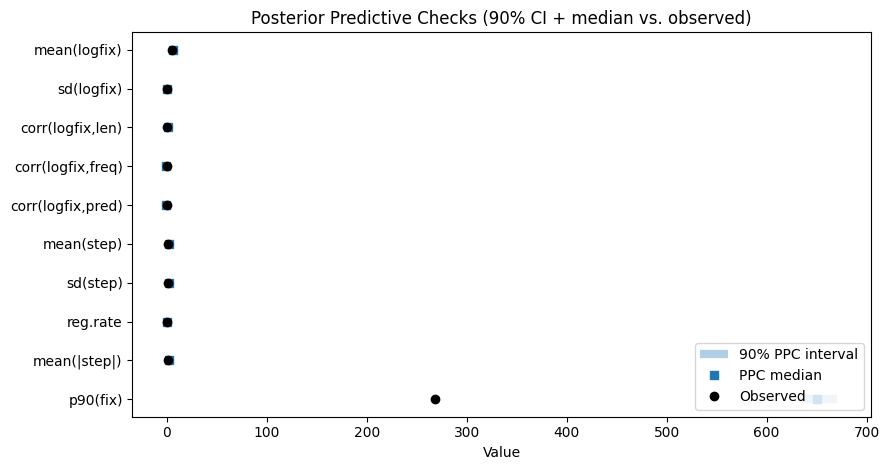

In [72]:
import os, numpy as np, matplotlib.pyplot as plt
RESULT_DIR = "/content/swift_outputs"; os.makedirs(RESULT_DIR, exist_ok=True)

# Fast PPC if you don't have one yet
def simulate_ppc_fast(theta_mat, n_rep=400, subset_sents=12, max_fix=100):
    theta_mat = np.asarray(theta_mat)
    if theta_mat.ndim == 1: theta_mat = theta_mat[None,:]
    sids = np.random.choice(list(SENTS.keys()), size=min(subset_sents, len(SENTS)), replace=False)
    sims = []
    for _ in range(n_rep):
        th = theta_mat[np.random.randint(theta_mat.shape[0])]
        sims.append(_simulator_fast_ultra(th, sids, max_fix))
    return np.stack(sims, axis=0)

ps = np.asarray(posterior_samples)
if ps.ndim == 3 and ps.shape[0] == 1: ps = ps[0]
elif ps.ndim == 1: ps = ps[None,:]

ppc = simulate_ppc_fast(ps, n_rep=400, subset_sents=12, max_fix=100)

labels = ["mean(logfix)","sd(logfix)","corr(logfix,len)","corr(logfix,freq)","corr(logfix,pred)",
          "mean(step)","sd(step)","reg.rate","mean(|step|)","p90(fix)"]

lo, md, hi = np.percentile(ppc, [5,50,95], axis=0)
y = np.arange(len(OBS_SUM))

plt.figure(figsize=(9,4.8))
plt.hlines(y, lo, hi, lw=6, alpha=.35, label="90% PPC interval")
plt.plot(md, y, "s", label="PPC median")
plt.plot(OBS_SUM, y, "o", ms=6, label="Observed", color="k")
plt.yticks(y, labels); plt.gca().invert_yaxis()
plt.xlabel("Value"); plt.title("Posterior Predictive Checks (90% CI + median vs. observed)")
plt.legend(loc="lower right")
plt.tight_layout(); plt.savefig(os.path.join(RESULT_DIR, "ppc_bars.png"), dpi=160); plt.show()


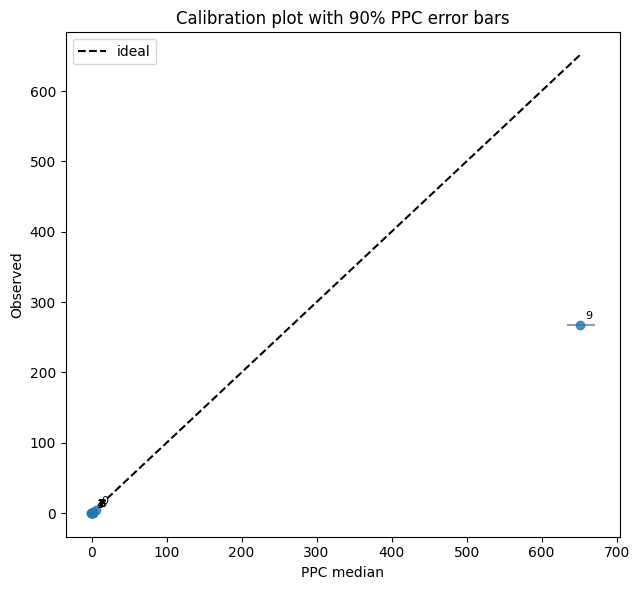

Index → stat mapping: {0: 'mean(logfix)', 1: 'sd(logfix)', 2: 'corr(logfix,len)', 3: 'corr(logfix,freq)', 4: 'corr(logfix,pred)', 5: 'mean(step)', 6: 'sd(step)', 7: 'reg.rate', 8: 'mean(|step|)', 9: 'p90(fix)'}


In [74]:
import numpy as np, matplotlib.pyplot as plt, os
labels = ["mean(logfix)","sd(logfix)","corr(logfix,len)","corr(logfix,freq)","corr(logfix,pred)",
          "mean(step)","sd(step)","reg.rate","mean(|step|)","p90(fix)"]

lo, md, hi = np.percentile(ppc, [5,50,95], axis=0)
x = md; xerr = np.vstack([md-lo, hi-md])
y = OBS_SUM

mn = np.minimum(x.min(), y.min()); mx = np.maximum(x.max(), y.max())

plt.figure(figsize=(6.5,6))
plt.errorbar(x, y, xerr=xerr, fmt="o", ecolor="gray", alpha=.8)
plt.plot([mn,mx],[mn,mx], "k--", lw=1.5, label="ideal")
for i, lab in enumerate(labels):
    plt.annotate(str(i), (x[i], y[i]), xytext=(4,4), textcoords="offset points", fontsize=8)
plt.xlabel("PPC median"); plt.ylabel("Observed"); plt.title("Calibration plot with 90% PPC error bars")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, "ppc_calibration.png"), dpi=160); plt.show()

print("Index → stat mapping:", {i:lab for i,lab in enumerate(labels)})


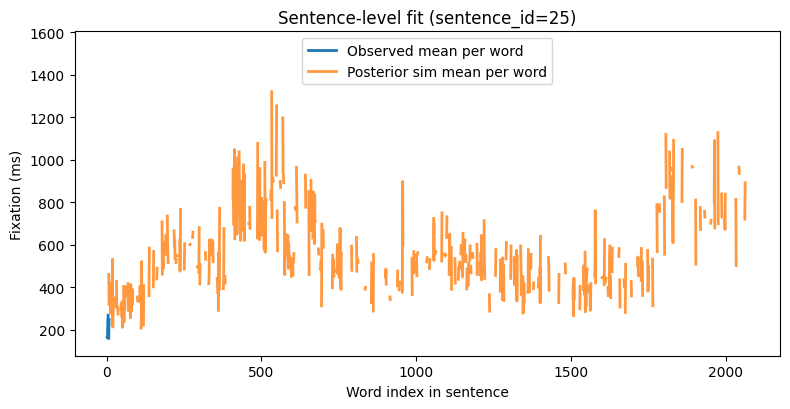

In [75]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os

# pick the longest sentence by number of words
sid_long = max(SENTS, key=lambda sid: len(SENTS[sid]))
g = SENTS[sid_long]  # observed dataframe for that sentence

# observed: mean fixation per word
obs_mean = g.groupby("word_index")["fix_dur_ms"].mean().reindex(range(len(g)), fill_value=np.nan).to_numpy()

# simulate from one posterior draw and aggregate mean per word
th = posterior_samples[np.random.randint(len(posterior_samples))]
sim = simulate_sentence(Theta(*th.tolist()), g)
sim_mean = np.full(len(g), np.nan, dtype=float)
if sim["logdur"].size:
    # average all fixations that landed on a given word
    for wi in np.unique(sim["landing_pos"]):
        sim_mean[wi] = np.exp(np.mean(sim["logdur"][sim["landing_pos"]==wi]))

plt.figure(figsize=(8,4.2))
plt.plot(obs_mean, label="Observed mean per word", lw=2)
plt.plot(sim_mean, label="Posterior sim mean per word", lw=2, alpha=.8)
plt.xlabel("Word index in sentence"); plt.ylabel("Fixation (ms)")
plt.title(f"Sentence-level fit (sentence_id={sid_long})")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, f"sentence_fit_sid{sid_long}.png"), dpi=160); plt.show()
